In [22]:
# 1. lade einen fliesstext rein [X]
# 2. loesche alle fuellwoerter (kann man mit tfidf machen) [X]
# 3. erstelle das skip-gram (wie viele im kontext links und rechts vom main word) [X]
# 4. fuege neue kombinationen (zero-labels) durch negative sampling hinzu (wie viele negative samples) [X]
# 5. main loop fuer embedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
cs_text = ""

with open("Computer Science Wikipedia.txt") as f:
    cs_text = f.read().replace("\n", "")
    
punctuation = [".", ",", ";", ":", "(", ")", "[", "]"]

for symbol in punctuation:
    cs_text = cs_text.replace(symbol, " ").lower()
    
cs_words = cs_text.split(" ")
cs_words = list(filter(lambda w : len(w) > 0, cs_words))

# filtere stop words heraus (die verwirren unser model nur)
stop_words = []

with open("stopwords.txt") as f:
    stop_words = f.read().replace("\n", " ").split(" ")

cs_words = list(filter(lambda w: w not in stop_words, cs_words))
print("This is the processed text based on which we want to find a word embedding: ")
print(cs_words)

This is the processed text based on which we want to find a word embedding: 
['computer', 'science', 'study', 'computation', 'automation', 'information', 'computer', 'science', 'spans', 'theoretical', 'disciplines', 'algorithms', 'theory', 'computation', 'information', 'theory', 'automation', 'practical', 'disciplines', 'including', 'design', 'implementation', 'hardware', 'software', 'computer', 'science', 'generally', 'considered', 'area', 'academic', 'research', 'distinct', 'computer', 'programming', 'algorithms', 'data', 'structures', 'central', 'computer', 'science', '6', 'theory', 'computation', 'concerns', 'abstract', 'models', 'computation', 'general', 'classes', 'problems', 'solved', 'using', 'fields', 'cryptography', 'computer', 'security', 'involve', 'studying', 'means', 'secure', 'communication', 'preventing', 'security', 'vulnerabilities', 'computer', 'graphics', 'computational', 'geometry', 'address', 'generation', 'images', 'programming', 'language', 'theory', 'considers'

In [3]:
# context_size : welche z.B. drei Worte stehen links vom wort, welche drei worte stehen rechts vom wort

def get_positive_samples(words, context_size):
    
    # main word, context word, label
    positive_samples = []
    
    for i, word in enumerate(words):
        
        max_to_left = max(0, i-3)
        max_to_right = min(len(words) - 1, i+3)
        
        words_left = words[max_to_left:i]
        words_right = words[i+1:max_to_right]
        
        for word_left in words_left:
            positive_samples.append((word, word_left, 1))
        
        for word_right in words_right:
            positive_samples.append((word, word_right, 1))
            
    return positive_samples

In [4]:
import random

seed = 40
random.seed(seed)

def get_negative_samples(words, context_size, samples_per_word = 3):
    
    # main word, context word, label
    negative_samples = []
    
    for i, word in enumerate(words):
        
        max_to_left = max(0, i-3)
        max_to_right = min(len(words) - 1, i+3)
        
        words_left = words[max_to_left:i]
        words_right = words[i+1:max_to_right]
        
        words_not_in_context = list(filter(lambda w : w not in words_left and w not in words_right, words))
        
        words_not_in_context = random.sample(words_not_in_context, k = samples_per_word)
        
        for word_not in words_not_in_context:
            negative_samples.append((word, word_not, 0))
            
    return negative_samples

In [16]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [53]:
learning_rate = 0.05

def update_per_entry(skip_gram_entry, main_vectors, context_vectors):
    
    (main_word, context_word, label) = skip_gram_entry
    
    main_vector = main_vectors[word_to_idx[main_word]]
    context_vector = context_vectors[word_to_idx[context_word]]
    
    score = sigmoid(np.dot(main_vector, context_vector))
    
    error = label - score
    
    # wenn error positiv, dann heisst es: label war 1 aber score war kleiner, d.h. naeher zusammenruecken
    # d.h. man sollte main_vector auf context vector hinzubewegen
    diff = context_vector - main_vector
    
    # gibt einen vektor zurueck, in welche richtung man sich bewegen soll
    return error * diff * learning_rate

In [54]:
def update(main_vectors, context_vectors, skip_gram, word_to_idx):
    
    # hier werden die updates zwischen gespeichert (man darf nicht updaten, solange man noch iteriert)
    update_main_vectors = np.zeros(main_vectors.shape)
    update_context_vectors = np.zeros(context_vectors.shape)
    
    for skip_gram_entry in skip_gram:
        
        main_word, context_word, label = skip_gram_entry
        
        update_val = update_per_entry(skip_gram_entry, main_vectors, context_vectors)
        
        update_main_vectors[word_to_idx[main_word]] += update_val
        update_context_vectors[word_to_idx[context_word]] -= update_val
    
    
    main_vectors += update_main_vectors
    context_vectors += update_context_vectors
    
    return normalize(main_vectors, axis=1, norm="l2"), normalize(context_vectors, axis=1, norm = "l2")

In [55]:
def find_embedding(words, n_iterations = 1000, context_size = 2, embedding_size = 2, negative_samples_per_word = 2):
    
    # skip gram generieren
    positive_samples = get_positive_samples(cs_words, context_size=2)
    negative_samples = get_negative_samples(cs_words, context_size = 2, samples_per_word = 2)
    skip_gram = positive_samples + negative_samples
    
    # jedes wort bekommt einen index
    word_to_idx = dict()

    for i, word in enumerate(words):
        word_to_idx[word] = i

    main_vectors = np.random.random((len(words), embedding_size))
    context_vectors = np.random.random((len(words), embedding_size))
    
    for i in range(n_iterations):
        
        main_vectors, context_vectors = update(main_vectors, context_vectors, skip_gram, word_to_idx)
        
    return main_vectors

In [61]:
# plots muessen groesser sein
plt.rcParams["figure.figsize"] = [10, 10]

def plot_embedding_2D(words, embedding, title):
    
    assert(embedding.shape[1] == 2)

    plt.title(title)
    plt.scatter(embedding[:, 0], embedding[:, 1])

    for i, word in enumerate(words):
        plt.text(embedding[i][0], embedding[i][1], word)

    plt.show()

In [62]:
from sklearn.decomposition import PCA

def plot_embedding(words, embedding, title):
    
    if embedding.shape[1] == 2:
        
        plot_embedding_2D(words, embedding, title)
        
    else:
        
        embedding2D = PCA(n_components = 2).fit_transform(embedding)
        plot_embedding_2D(words, embedding2D, title)

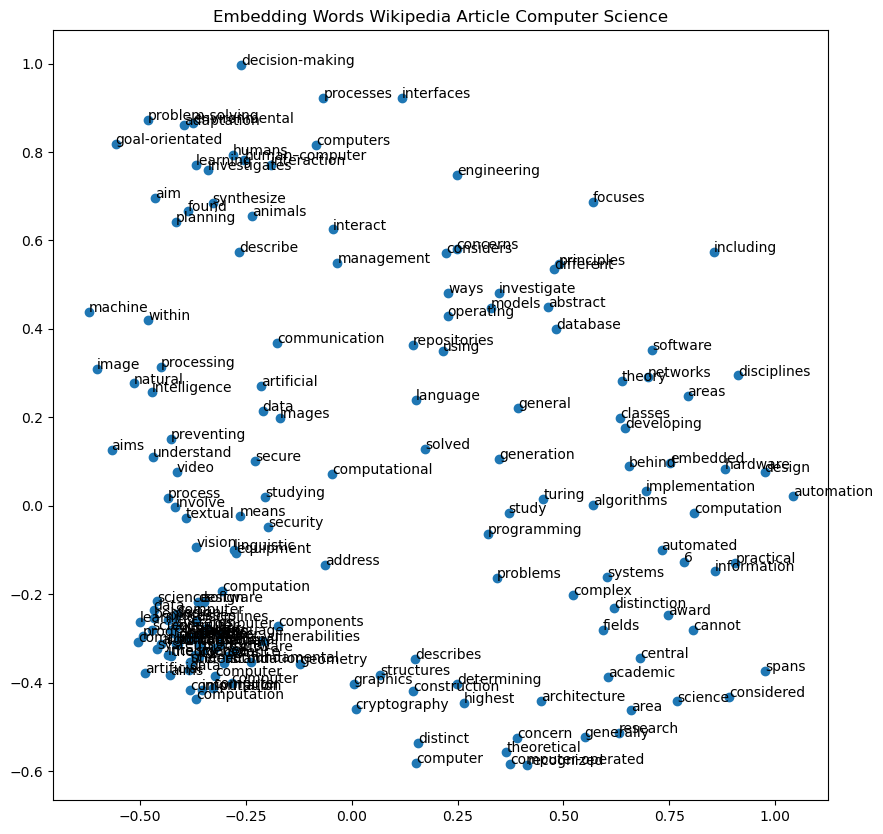

In [101]:
embeddingCS = find_embedding(cs_words, embedding_size = 50, context_size=2, negative_samples_per_word = 4)
plot_embedding(cs_words, embeddingCS, title="Embedding Words Wikipedia Article Computer Science")

In [77]:
def find_nearest_word(point, embedding, words):
    
    distances_to_point = np.linalg.norm(embedding - point, axis=1)
    idx = np.argmin(distances_to_point)
    return words[idx]

In [79]:
# hier kommt wieder ein Wort im Wortraum raus
def add_words(embedding, words, first_word, second_word):
    
    first_word = first_word.lower()
    second_word = second_word.lower()
    
    first_idx = words.index(first_word)
    second_idx = words.index(second_word)
    
    first_point = embedding[first_idx]
    second_point = embedding[second_idx]
    
    return find_nearest_word(first_point + second_point, embedding, words)

In [84]:
# hier kommt wieder ein Wort im Wortraum raus
def subtract_words(embedding, words, first_word, second_word):
    
    first_word = first_word.lower()
    second_word = second_word.lower()
    
    first_idx = words.index(first_word)
    second_idx = words.index(second_word)
    
    first_point = embedding[first_idx]
    second_point = embedding[second_idx]
    
    return find_nearest_word(first_point - second_point, embedding, words)

In [102]:
add_words(embeddingCS, cs_words, "research", "award")

'science'

In [127]:
subtract_words(embeddingCS, cs_words, "problems", "academic")

'solved'